# Assignment 1: Comparison of Regression Models on Predicting Medical Costs

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
![Medical Cost](https://creditkarma-cms.imgix.net/wp-content/uploads/2018/04/boomers-gen-x-high-cost-medical-care.jpg)
In this assignment, you will implement some learning models in the context of a **regression** problem in the [Medical Cost Personal Dataset on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Specifically, you will attempt to predict the medical cost billed by health insurance using other provided patient's data. For references, you may refer to [my slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit#slide=id.p) or the Google Colab if you need additional sample codes to help with your assignment. To get started, you will need to upload/copy the dataset (.csv) into the same folder as this file. 

For deliverables, you must write code in Colab and submit the downloaded Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.


***
##  Task 1: SEE THE BIG PICTURE (5 pts)
Write a paragraph explaining the context of the problem in which you are trying to investigate. We will assume that the data file is put into the same workspace on Colab. Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is your dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * Does it contain any categorical data?
 * Is there any missing value?
 * What are some basic statistics you can learn right away about this dataset?

In [140]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Your code goes here for this section, make sure you also include the output to answer the above questions.
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd # Pandas module to enable data manipulation

def load_insurance_data(housing_path="/content/drive/My Drive/ML"):
    """Load Housing Data into Workspace from a CSV"""
    csv_path = os.path.join(housing_path, "insurance.csv")
    return pd.read_csv(csv_path, sep=',')
insurance = load_insurance_data()
# Display the first n rows of the data. (n=5 by default)
# insurance.head(10)
insurance.info()
# sample_incomplete_rows = insurance[insurance.isnull().any(axis=1)].head()
# sample_incomplete_rows


print("How big is your dataset? (in terms of MB) : 56KB = 56,000 MB")
print("How many entries does it have? : 1338 entries")
print("How many features does it have? : 7 features (6 for prediction)")
print("Does it contain any categorical data? : yes")
print("Is there any missing value? : no missing values")
print("What are some basic statistics you can learn right away about this dataset? : ")

insurance.describe()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
How big is your dataset? (in terms of MB) : 56KB = 56,000 MB
How many entries does it have? : 1338 entries
How many features does it have? : 7 features (6 for prediction)
Does it contain any categorical data? : yes
Is there any missing value? : no missing values
What are some basic statistics you can learn right away about this dataset? : 


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


---
##  Task 2: DATA DISCOVERY, CLEANING, AND SCALING (25 pts)

**Data Discover:** Plot out all correlations among the features. You may notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. If your dataset has categorical features, make sure you conver those features into numerical using OneHotEncoder class. 

**Feature Scaling** More importantly, your task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

**Implementation Note:** You will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96f00f4f60>,
      dtype=object)

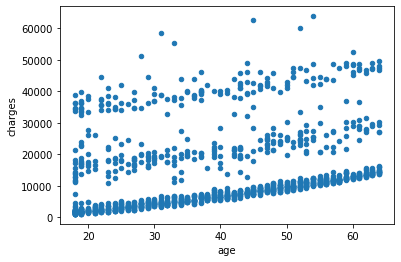

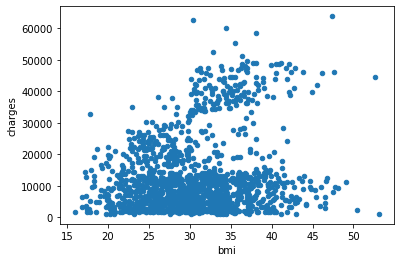

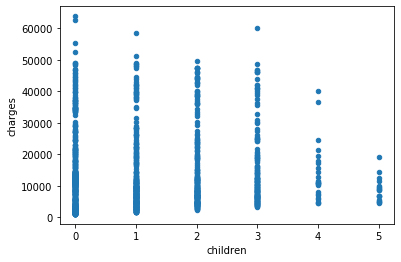

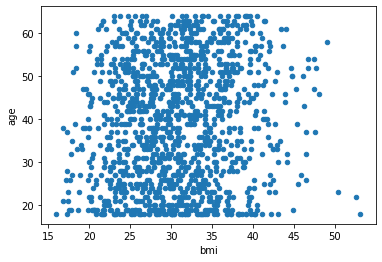

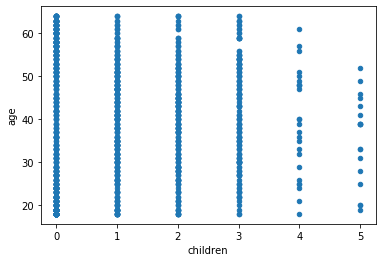

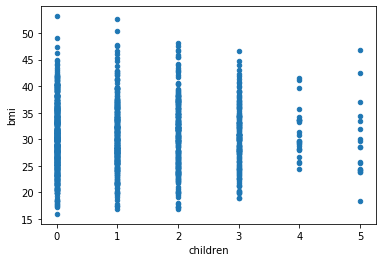

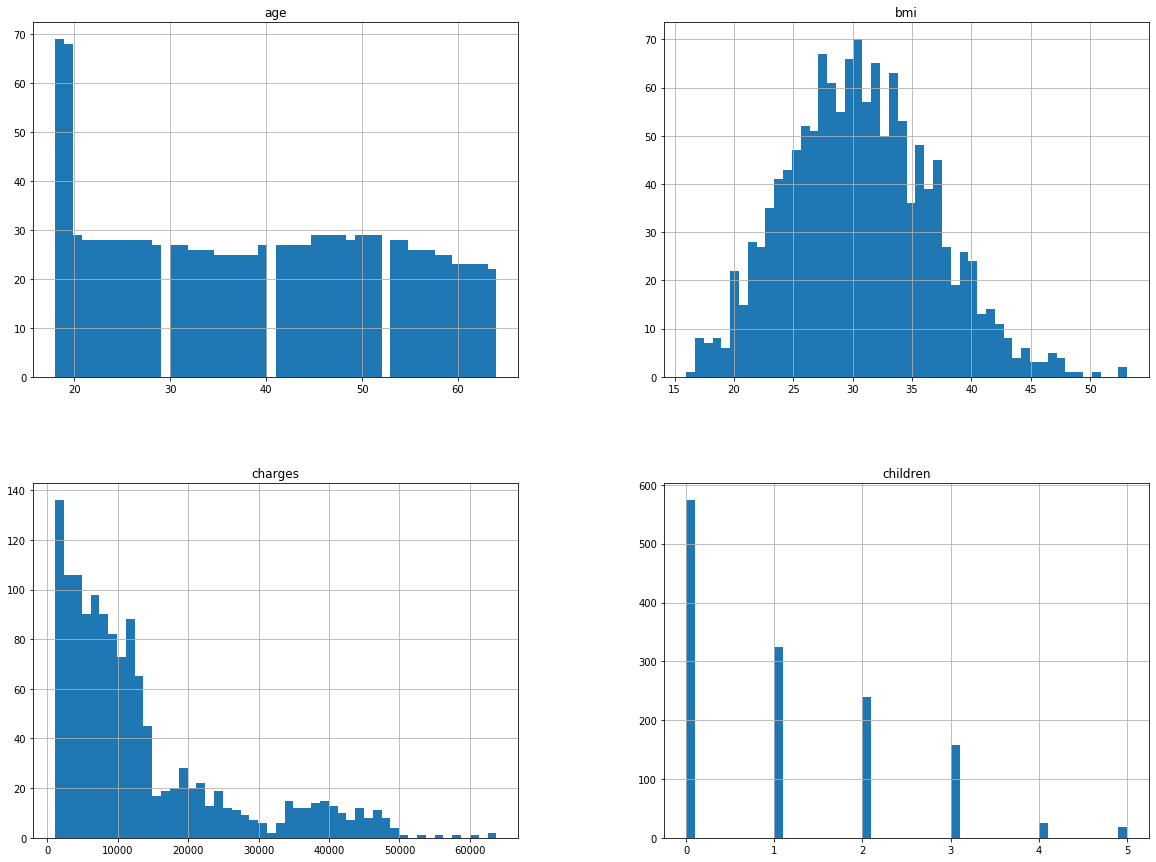

In [141]:
import matplotlib.pyplot as plt
insurance.plot(kind="scatter", x="age", y="charges")
insurance.plot(kind="scatter", x="bmi", y="charges")
insurance.plot(kind="scatter", x="children", y="charges")
insurance.plot(kind="scatter", x="bmi", y="age")
insurance.plot(kind="scatter", x="children", y="age")
insurance.plot(kind="scatter", x="children", y="bmi")
# insurance.plot(kind="scatter", x="age", y="charges")
insurance.hist(bins=50, figsize=(20,15))


In [142]:
# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy="median")

from sklearn.compose import ColumnTransformer

# insurance_prepared = full_pipeline.fit_transform(insurance)
# insurance_prepared

train_set, test_set = train_test_split(insurance, test_size=0.2, random_state=42)
# # Your code goes here for this section.
X_train = train_set.drop("charges", axis = 1)
y_train = train_set["charges"]
X_test = test_set.drop("charges", axis = 1)
y_test = test_set["charges"]

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

insurance_num_train = X_train.drop(["sex", "smoker", "region"], axis=1)
num_attribs_train = list(insurance_num_train)
cat_attribs_train = ["sex", "smoker", "region"]

full_pipeline_train = ColumnTransformer([
        ("num", num_pipeline, num_attribs_train),
        ("cat", OneHotEncoder(), cat_attribs_train),
    ])


insurance_num_test = X_test.drop(["sex", "smoker", "region"], axis=1)
num_attribs_test = list(insurance_num_test)
cat_attribs_test = ["sex", "smoker", "region"]

full_pipeline_test = ColumnTransformer([
        ("num", num_pipeline, num_attribs_test),
        ("cat", OneHotEncoder(), cat_attribs_test),
    ])

X_train_final = np.array(full_pipeline_train.fit_transform(X_train))
y_train_final = np.array(y_train)
X_test_final = np.array(full_pipeline_test.fit_transform(X_test))
y_test_final = np.array(y_test)

# corr_matrix = np.corrcoef(insurance_prepared, rowvar=False)
# print(corr_matrix)
# plt.matshow(corr_matrix)
# plt.show()
# insurance.head(10)

# insurance_prepared

X_train_final.shape



(1070, 11)

- - -
## Task 3. IMPLEMENT GRADIENT DESCENT (30 pts)
The gradient descent formulation remain the same as one in the lecture. Keep in mind that you will need to add a column $\textbf{x}_0$ with all 1s as part of the training data. You should write code to implement the **MyLinearRegression** class and its predefined methods. 

**Gradient Descent:** Notes that you may NOT call the library linear regression which defeats the purpose of this assignment. Make sure your code is well-vectorized.

In [0]:
# NOTE: You may not use the library Linear Regression, but implement your own!
# REMEMBER to place self.attribute = 0 with value from your implementation

class MyLinearRegression:
  """
  Define what a linear regressor can do
  """

  def __init__ (self):
    """
    Initialize the regressor
    """
    self.theta = np.ones((11,1)); # parameter vector;
    self.alpha = .005; # learning rate
    self.cost  = []; # cost function

  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations

    OUTPUT: 
    theta: updated value for theta
    cost: value of the cost function
    """
    # implementation code here
    cost = []
    for i in range(iters):
      grads = 2/X_train.shape[0] * X_train.T.dot(X_train.dot(theta).reshape(y_train.shape)-y_train)
      # print(X_train.dot(theta).shape)
      temp = (X_train.dot(theta).reshape(y_train.shape) - y_train)
      # temp = 1 / X_train.shape[0] * temp.T.dot(temp)
      
      theta = theta - alpha * grads.reshape((11,1))
      # print(X_train.dot(theta).shape)
      # temp = (X_train.dot(theta).reshape(y_train.shape) - y_train)
      cost.append(1 / X_train.shape[0] * temp.T.dot(temp))
    self.cost = cost
    return (theta, self.cost)


  def fitUsingGradientDescent(self, X_train, y_train):
    """
    Train the regressor using gradient descent
    """
    # implementation code here
    (self.theta, self.cost) = self.gradientDescent(X_train, y_train, self.theta, self.alpha, 1000)


  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    # implementation code here for Task 4.
    X_b = np.c_[np.ones((1070, 1)), X_train]
    # X_b = X_train
    self.theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train);

  def predict(self, X_test):
    """
    Predicting the label
    """
    # implementation code here 
    if self.theta.shape == (12,):
      X_b = np.c_[np.ones((268, 1)), X_test]
      return X_b.dot(self.theta)
    return X_test.dot(self.theta)

  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    # implement here to return("Parameter vector is %f" % self.theta)   }
    print("Parameter vector is %f" % self.theta)
# Your code goes here to call the instance of class MyLinearRegression
# myGradientDescentModel = MyLinearRegression()
#myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)    

* **Learning Rate:** You will try out different learning rates for the dataset and find a learning rate that converges quickly. If you pick a learning rate, your plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that your implementation is correct. If your learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, you must be able to report the best learning rate the you found to earn credit for this section.

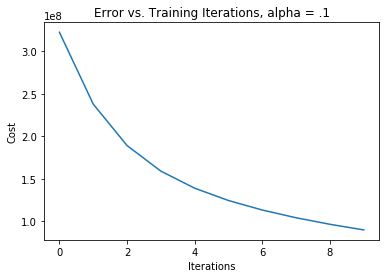

In [144]:
myGradientDescentModel = MyLinearRegression()
myGradientDescentModel.gradientDescent(X_train_final, y_train_final, myGradientDescentModel.theta, .1, 10)
iters = []
for i in range(10):
  iters.append(i)
plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Iterations, alpha = .1')
plt.plot(iters,myGradientDescentModel.cost) 

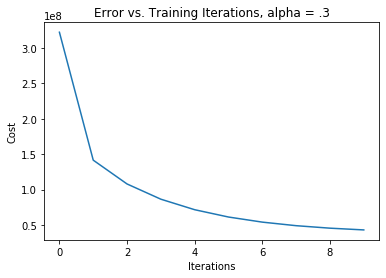

In [145]:
myGradientDescentModel = MyLinearRegression()
myGradientDescentModel.gradientDescent(X_train_final, y_train_final, myGradientDescentModel.theta, .3, 10)
iters = []
for i in range(10):
  iters.append(i)
plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Iterations, alpha = .3')
plt.plot(iters,myGradientDescentModel.cost) 

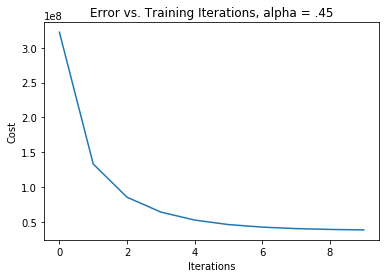

In [146]:
myGradientDescentModel = MyLinearRegression()
myGradientDescentModel.gradientDescent(X_train_final, y_train_final, myGradientDescentModel.theta, .45, 10)
iters = []
for i in range(10):
  iters.append(i)
plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Iterations, alpha = .45')
plt.plot(iters,myGradientDescentModel.cost) 

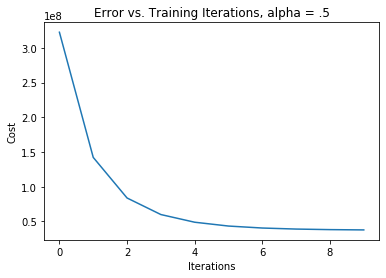

In [147]:
myGradientDescentModel = MyLinearRegression()
myGradientDescentModel.gradientDescent(X_train_final, y_train_final, myGradientDescentModel.theta, .5, 10)
iters = []
for i in range(10):
  iters.append(i)
plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Iterations, alpha = .5')
plt.plot(iters,myGradientDescentModel.cost) 

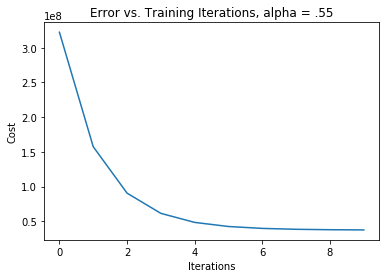

In [148]:
myGradientDescentModel = MyLinearRegression()
myGradientDescentModel.gradientDescent(X_train_final, y_train_final, myGradientDescentModel.theta, .55, 10)
iters = []
for i in range(10):
  iters.append(i)
plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Iterations, alpha = .55')
plt.plot(iters,myGradientDescentModel.cost) 

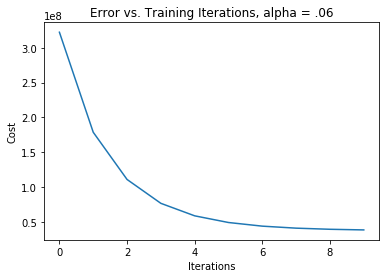

In [149]:
myGradientDescentModel = MyLinearRegression()
myGradientDescentModel.gradientDescent(X_train_final, y_train_final, myGradientDescentModel.theta, .6, 10)
iters = []
for i in range(10):
  iters.append(i)
plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Iterations, alpha = .06')
plt.plot(iters,myGradientDescentModel.cost) 

The best learning rate I found was .5

- - -
## Task 4. IMPLEMENT THE NORMAL EQUATION (10 pts)

In my lecture, you learn that the closed form solution of linear regression using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement: 

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that you still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [0]:
# Implement the normalEquation method of the MyLinearRegression Class before execute the code below:
myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train_final, y_train_final)

- - -
## Task 5. COMPARE DIFFERENT IMPLEMENTATIONS (20 pts)

You should be able to evaluate and compare your gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measures, you may also use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, you must compute the RMSE on the **test set** as performance measure. The good news is that you can call library functions to compute these as shown below instead of writing your own code:

* Which one yields the best performance measure for your dataset?
* What is your assessment of the error? Good? Okay? Terrible?

In [151]:
from sklearn.metrics import mean_squared_error
from math import sqrt


# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor()
mySGDModel.fit(X_train_final,y_train_final)
y_predict = mySGDModel.predict(X_test_final)
mse = mean_squared_error(y_test_final, y_predict)
mySGDModel_rmse = np.sqrt(mse)
print("mySGDModel_rmse:" , mySGDModel_rmse)

myGradientDescentModel = MyLinearRegression()
myGradientDescentModel.fitUsingGradientDescent(X_train_final, y_train_final)
myGradientDescentModel_rmse = sqrt(mean_squared_error(y_test_final, myGradientDescentModel.predict(X_test_final)))
print("myGradientDescentModel_rmse:", myGradientDescentModel_rmse)

myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train_final, y_train_final)
myNormalEquationModel_rmse = sqrt(mean_squared_error(y_test_final, myNormalEquationModel.predict(X_test_final)))
print("myNormalEquationModel_rmse:", myNormalEquationModel_rmse)

mySGDModel_rmse: 5799.591810991122
myGradientDescentModel_rmse: 5907.461806488033
myNormalEquationModel_rmse: 9462.247104641756


mySGDModel_rmse: 5787.453055373627

myGradientDescentModel_rmse: 5907.461806488033

myNormalEquationModel_rmse: 9462.247104641756

The best one is the Scholastic Gradient Descent and the second best is my own implementation of Gradient Descent. The normal equation model did the worst.

A RMSE of 5907 is pretty high, considering that the average charge is 13270.
However the standard deviation is 12110, so the error is reasonable.

- - -
## Task 6. PRESENT YOUR SOLUTION (10 pts)

Now that you need to write a short memo of one paragraph to be read by a non-technical audience (ie. your manager/boss). Focus on answering the following: 

* How can you pitch your solution to this project? 
* What did you learn so far about the problem?
* Is there any insight moving forward to improve the solution.

In [0]:
# Your paragraph goes here for this section

#     I was able to use 3 different models to predict
#  the cost of insurance for a person given their age, sex, bmi,
#  number of children, whether or not they smoke, and their region.
#  We can use this information as a guide to help decide how much
#  money to charge a new customer. However, the current model predicts 
#  with some error, which can be high at times. In order to make the model
#  better at predicting, we could try collecting more data samples, as well
#  as more information per person.

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit?usp=sharing) and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](http://bit.ly/cs4774oh)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 1:...".

Best of luck and have fun!